## House Price Prediction using Ridge and Lasso Regression

The solution is divided into the following sections: 
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation

### 1. Data Understanding and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [53]:
# reading the dataset
houses = pd.read_csv("train.csv")

In [54]:
# summary of the dataset: 1460 rows, 81 columns, null values present
print(houses.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [55]:
# head
houses.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Understanding the Data Dictionary

The data dictionary contains the meaning of various attributes; some non-obvious ones are:

In [56]:
# identifies the type of dwelling involved in the sale
# Majority of the houses are 20 means 1-STORY 1946 & NEWER ALL STYLES
# 60 means 2-STORY 1946 & NEWER
# 50 means 1-1/2 STORY FINISHED ALL AGES
houses['MSSubClass'].astype('category').value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [57]:
# identifies the general zoning classification of the sale
# Most houses are RL means Residential Low Density
houses['MSZoning'].astype('category').value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [58]:
# LandSlope: Gentle, Moderate or severe slope 
houses['LandSlope'].astype('category').value_counts()

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

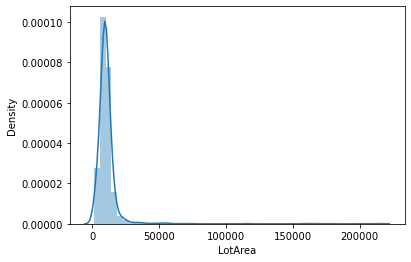

In [59]:
# LotArea: Lot size in square feet
sns.distplot(houses['LotArea'])
plt.show()

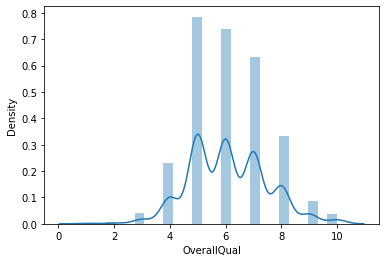

In [60]:
# OverallQual: Rates the overall material and finish of the house
# 1 Very Poor 5 Average 10 Very Excellent
sns.distplot(houses['OverallQual'])
plt.show()

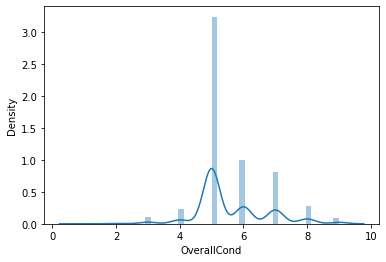

In [61]:
# OverallCond: Rates the overall condition of the house
# 1 Very Poor 5 Average 10 Very Excellent
sns.distplot(houses['OverallCond'])
plt.show()

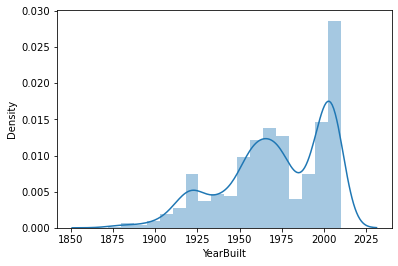

In [62]:
# YearBuilt: Original construction date
sns.distplot(houses['YearBuilt'])
plt.show()

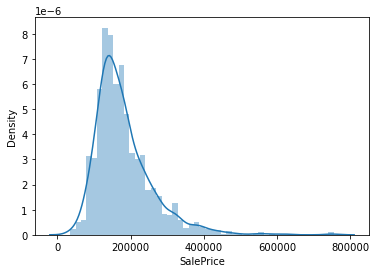

In [63]:
# target variable: price of house
sns.distplot(houses['SalePrice'])
plt.show()

#### Data Exploration

To perform linear regression, the (numeric) target variable should be linearly related to *at least one another numeric variable*. Let's see whether that's true in this case.


We'll first subset the list of all (independent) numeric variables, and then make a **pairwise plot**.

In [64]:
# all numeric (float and int) variables in the dataset
houses_numeric = houses.select_dtypes(include=['float64', 'int64'])
houses_numeric.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [65]:
# dropping Id 
houses_numeric = houses_numeric.drop(['Id'], axis=1)
houses_numeric.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


This is quite hard to read, and we can rather plot correlations between variables. Also, a heatmap is pretty useful to visualise multiple correlations in one plot.

In [66]:
# correlation matrix
cor = houses_numeric.corr()
cor

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378


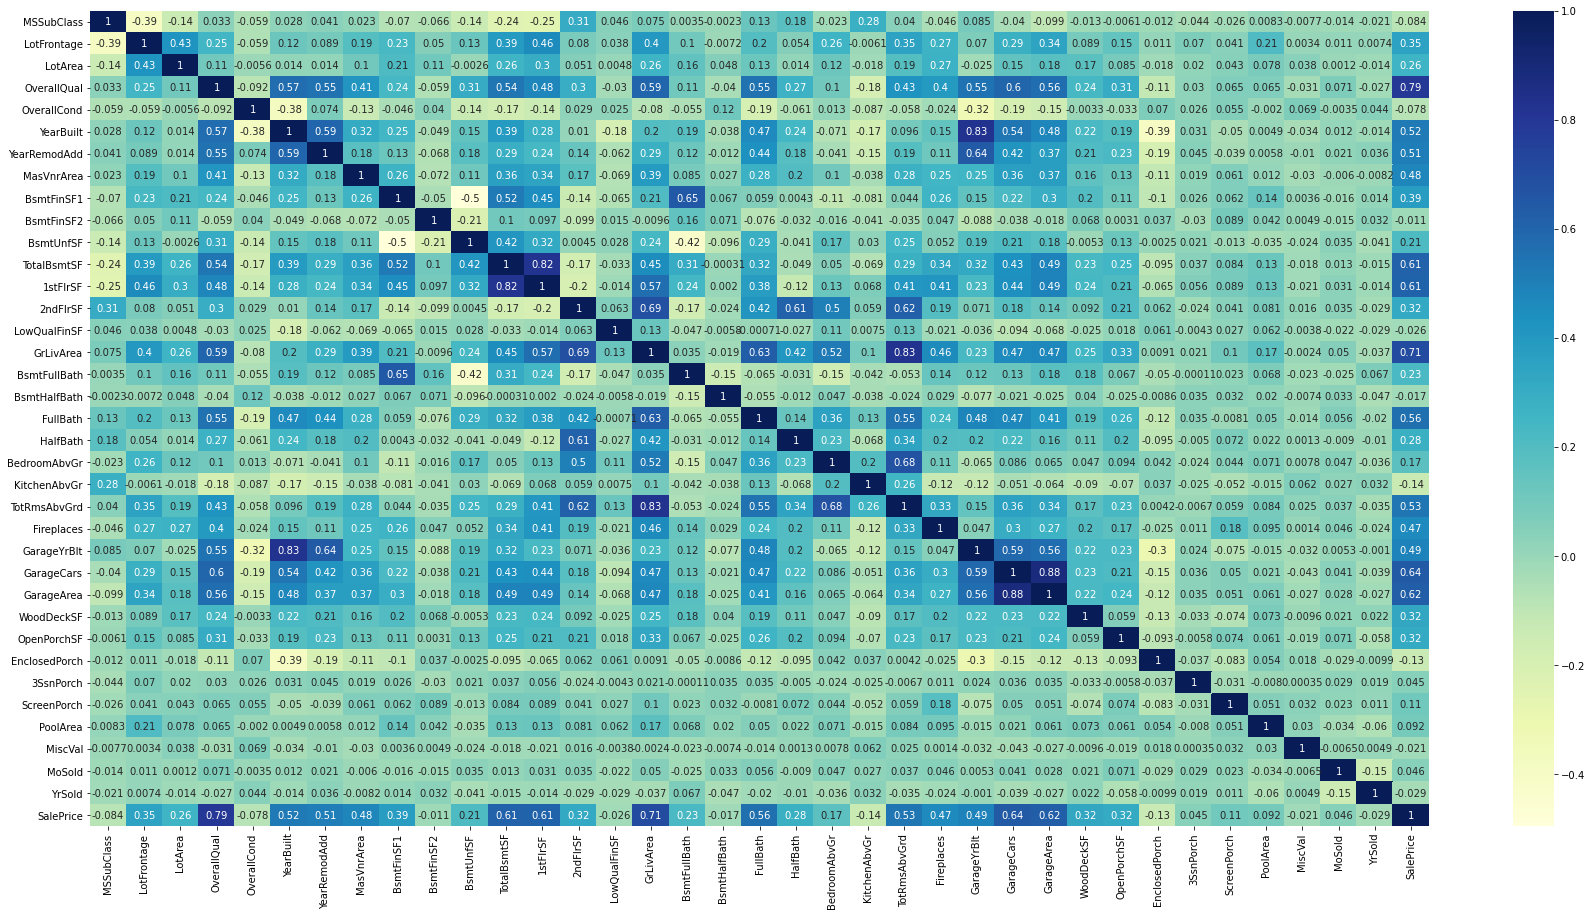

In [127]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(30,15))

# heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

The heatmap shows some useful insights:

Correlation of SalePrice with independent variables:
- Price is highly (positively) correlated with OverallQual(0.79), GrLivArea(0.71), GarageCars(0.64), GarageArea(0.61), TotalBsmtSF, 1stFlrSF, FullBath, TotRmsAbvGrd, YearBuilt and YearRemodAdd

- Price is negatively correlated to KitchenAbvGr, EnclosedPorch, MsSubClass, OverallCond and Yrsold

Correlation among independent variables:
- Some of the independent variables are highly positively correlated like 
    a) GarageCars, GarageArea, GarageYrBlt
    b) TotalBsmtSF, 1stFlrSF
    

Thus, while building the model, we'll have to pay attention to multicollinearity (especially linear models, such as linear and logistic regression, suffer more from multicollinearity).

## 2. Data Cleaning

Let's now conduct some data cleaning steps. 

We've seen that there are missing values in the dataset. 

In [68]:
# finding the percentage of missing value
# summing up the missing values (column-wise) and displaying fraction of NaNs
round(100*(houses.isnull().sum()/len(houses)),2)

Id                0.00
MSSubClass        0.00
MSZoning          0.00
LotFrontage      17.74
LotArea           0.00
                 ...  
MoSold            0.00
YrSold            0.00
SaleType          0.00
SaleCondition     0.00
SalePrice         0.00
Length: 81, dtype: float64

In [69]:
#removing columns with high missing values
#finding the list of columns with any missing value
missing_col_list = round(100*(houses.isnull().sum()/len(houses.Id)), 2)
missing_col_list.loc[missing_col_list > 0]

LotFrontage     17.74
Alley           93.77
MasVnrType       0.55
MasVnrArea       0.55
BsmtQual         2.53
BsmtCond         2.53
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtFinType2     2.60
Electrical       0.07
FireplaceQu     47.26
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
PoolQC          99.52
Fence           80.75
MiscFeature     96.30
dtype: float64

In [70]:
#listing the columns with more than 80% missing values
missing_columns_list = list(missing_col_list[missing_col_list >= 80].index)
len(missing_columns_list)

4

In [71]:
#dropping the columns with more than 80% missing values
houses = houses.drop(missing_columns_list,axis=1)
houses.shape

(1460, 77)

In [72]:
#lets handle rest of the missing value columns 
remaining_missing_val_columns = round(100*(houses.isnull().sum()/len(houses)),2)
remaining_missing_val_columns[remaining_missing_val_columns !=0 ]

LotFrontage     17.74
MasVnrType       0.55
MasVnrArea       0.55
BsmtQual         2.53
BsmtCond         2.53
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtFinType2     2.60
Electrical       0.07
FireplaceQu     47.26
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
dtype: float64

In [74]:
#dropping FireplaceQu column
houses = houses.drop(['FireplaceQu'], axis = 1)

In [75]:
remaining_missing_val_columns = round(100*(houses.isnull().sum()/len(houses)),2)
remaining_missing_val_columns[remaining_missing_val_columns !=0 ]

LotFrontage     17.74
MasVnrType       0.55
MasVnrArea       0.55
BsmtQual         2.53
BsmtCond         2.53
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtFinType2     2.60
Electrical       0.07
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
dtype: float64

In [76]:
#LotFrontage contains info regarding Linear feet of street connected to property
# delete the rows having above missing values
houses=houses[~houses.LotFrontage.isnull()]

In [77]:
remaining_missing_val_columns = round(100*(houses.isnull().sum()/len(houses)),2)
remaining_missing_val_columns[remaining_missing_val_columns !=0 ]

MasVnrType      0.50
MasVnrArea      0.50
BsmtQual        2.58
BsmtCond        2.58
BsmtExposure    2.66
BsmtFinType1    2.58
BsmtFinType2    2.66
Electrical      0.08
GarageType      6.16
GarageYrBlt     6.16
GarageFinish    6.16
GarageQual      6.16
GarageCond      6.16
dtype: float64

In [78]:
#MasVnrType contains info regarding Masonry veneer type
#MasVnrArea contains info regarding Masonry veneer area in square feet
#Electrical contains info regarding Electrical system
# delete the rows having above missing values
houses=houses[~houses.MasVnrType.isnull()]
houses=houses[~houses.MasVnrArea.isnull()]
houses=houses[~houses.Electrical.isnull()]

In [79]:
remaining_missing_val_columns = round(100*(houses.isnull().sum()/len(houses)),2)
remaining_missing_val_columns[remaining_missing_val_columns !=0 ]

BsmtQual        2.60
BsmtCond        2.60
BsmtExposure    2.68
BsmtFinType1    2.60
BsmtFinType2    2.68
GarageType      6.20
GarageYrBlt     6.20
GarageFinish    6.20
GarageQual      6.20
GarageCond      6.20
dtype: float64

In [80]:
#BsmtQual: Evaluates the height of the basement
#BsmtCond: Evaluates the general condition of the basement
#BsmtExposure: Refers to walkout or garden level walls
#BsmtFinType1: Rating of basement finished area
#BsmtFinSF1: Type 1 finished square feet
# GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond
# delete the rows having above missing values
houses=houses[~houses.BsmtQual.isnull()]
houses=houses[~houses.BsmtCond.isnull()]
houses=houses[~houses.BsmtExposure.isnull()]
houses=houses[~houses.BsmtFinType1.isnull()]
houses=houses[~houses.BsmtFinType2.isnull()]
houses=houses[~houses.GarageType.isnull()]
houses=houses[~houses.GarageYrBlt.isnull()]
houses=houses[~houses.GarageFinish.isnull()]
houses=houses[~houses.GarageQual.isnull()]
houses=houses[~houses.GarageCond.isnull()]

In [81]:
remaining_missing_val_columns = round(100*(houses.isnull().sum()/len(houses)),2)
remaining_missing_val_columns[remaining_missing_val_columns !=0 ]

Series([], dtype: float64)

In [82]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1094 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1094 non-null   int64  
 1   MSSubClass     1094 non-null   int64  
 2   MSZoning       1094 non-null   object 
 3   LotFrontage    1094 non-null   float64
 4   LotArea        1094 non-null   int64  
 5   Street         1094 non-null   object 
 6   LotShape       1094 non-null   object 
 7   LandContour    1094 non-null   object 
 8   Utilities      1094 non-null   object 
 9   LotConfig      1094 non-null   object 
 10  LandSlope      1094 non-null   object 
 11  Neighborhood   1094 non-null   object 
 12  Condition1     1094 non-null   object 
 13  Condition2     1094 non-null   object 
 14  BldgType       1094 non-null   object 
 15  HouseStyle     1094 non-null   object 
 16  OverallQual    1094 non-null   int64  
 17  OverallCond    1094 non-null   int64  
 18  YearBuil

In [83]:
# outliers
houses.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,...,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000
mean,727.375686,56.128885,70.759598,10132.346435,6.247715,5.575868,1972.412249,1985.915905,109.855576,448.191956,...,94.341865,46.946984,22.053016,3.266910,16.498172,3.007313,23.550274,6.335466,2007.786106,187033.263254
std,420.955488,41.976345,24.508859,8212.249621,1.366797,1.066500,31.189752,20.930772,190.667459,468.728095,...,122.624615,64.820019,61.570502,29.655973,58.455303,40.713175,167.135237,2.694558,1.334307,83165.332151
min,1.000000,20.000000,21.000000,1300.000000,2.000000,2.000000,1880.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,35311.000000
25%,366.500000,20.000000,60.000000,7606.750000,5.000000,5.000000,1953.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,132500.000000
50%,723.500000,50.000000,70.000000,9444.500000,6.000000,5.000000,1975.000000,1995.000000,0.000000,384.500000,...,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,165750.000000
75%,1093.750000,70.000000,80.000000,11387.250000,7.000000,6.000000,2003.000000,2005.000000,171.750000,712.750000,...,169.750000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,221000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,648.000000,2500.000000,12.000000,2010.000000,755000.000000


In [84]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1094 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1094 non-null   int64  
 1   MSSubClass     1094 non-null   int64  
 2   MSZoning       1094 non-null   object 
 3   LotFrontage    1094 non-null   float64
 4   LotArea        1094 non-null   int64  
 5   Street         1094 non-null   object 
 6   LotShape       1094 non-null   object 
 7   LandContour    1094 non-null   object 
 8   Utilities      1094 non-null   object 
 9   LotConfig      1094 non-null   object 
 10  LandSlope      1094 non-null   object 
 11  Neighborhood   1094 non-null   object 
 12  Condition1     1094 non-null   object 
 13  Condition2     1094 non-null   object 
 14  BldgType       1094 non-null   object 
 15  HouseStyle     1094 non-null   object 
 16  OverallQual    1094 non-null   int64  
 17  OverallCond    1094 non-null   int64  
 18  YearBuil

## 3. Data Preparation 


#### Data Preparation

Let's now prepare the data and build the model.

In [85]:
# split into X and y
X = houses.loc[:, ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType','MasVnrArea','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure',
       'BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','Heating',
       'HeatingQC','CentralAir','Electrical','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
       'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','KitchenQual',
        'TotRmsAbvGrd','Functional','Fireplaces','GarageType','GarageYrBlt','GarageFinish',
        'GarageCars','GarageArea','GarageQual','GarageCond','PavedDrive','WoodDeckSF','OpenPorchSF',
        'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold',
        'SaleType','SaleCondition']] # predictors in variable X

y = houses['SalePrice'] # response variable in Y

In [86]:
# creating dummy variables for categorical variables

# subset all categorical variables
houses_categorical = X.select_dtypes(include=['object'])
houses_categorical.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


In [87]:
# convert into dummies - one hot encoding
houses_dummies = pd.get_dummies(houses_categorical, drop_first=True)
houses_dummies.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [88]:
# drop categorical variables 
X = X.drop(list(houses_categorical.columns), axis=1)

In [89]:
# concat dummy variables with X
X = pd.concat([X, houses_dummies], axis=1)

In [90]:
# scaling the features - necessary before using Ridge or Lasso
from sklearn.preprocessing import scale

# storing column names in cols, since column names are (annoyingly) lost after 
# scaling (the df is converted to a numpy array)
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=221)

In [91]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

## 3. Model Building and Evaluation

## Linear Regression

Let's now try predicting house prices, a dataset using linear regression.

In [92]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [93]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

-571237009401956.9
[ 2.37178272e+03  2.74639043e+03  8.14027937e+03  9.88428319e+03
  5.59134610e+03  7.06081771e+03  3.21619268e+03  6.15316636e+03
  3.38467718e+14  1.14867775e+14  3.21936392e+14 -3.00285452e+14
 -1.78603905e+16 -2.02368159e+16 -1.93954850e+15  2.42386558e+16
 -7.41275391e+02  3.36476562e+02  2.84542969e+03  5.04734375e+02
 -2.29855469e+03 -2.95548438e+03 -3.17328125e+03  1.24390625e+02
  1.42140234e+03  4.78147656e+03 -1.17358350e+03  2.00370898e+03
 -2.44373535e+02  6.48109375e+02  1.31060156e+03  1.96950940e+03
  5.19017188e+03  4.47367188e+02 -9.23403320e+01 -7.22773438e+02
  5.72605273e+03  8.99212891e+02  6.08867188e+03  5.42390953e+03
  2.94260547e+03  1.25706366e+03  1.18014648e+02 -3.08648438e+02
  1.09663989e+03 -2.91525781e+03  6.30653320e+02  3.47289844e+03
 -1.32002539e+03 -1.23395703e+03  6.42929688e+01  4.85199219e+02
 -2.89638281e+03 -3.71304688e+02 -9.65242188e+02 -2.39414453e+03
 -2.54376172e+03 -6.01125195e+03 -3.69603516e+02 -5.69444922e+03
 -4.90

In [94]:
from sklearn.metrics import r2_score, mean_squared_error

In [95]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.9512073832815422
-3.4423953322402522e+22
256098369900.48438
7.954904697540513e+34
334769110.98102534
2.4179041633861744e+32


## Ridge and Lasso Regression

Let's now try predicting house prices, a dataset used in simple linear regression, to perform ridge and lasso regression.

## Ridge Regression

In [96]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.3s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [97]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 500}


In [98]:
#Fitting Ridge model for alpha = 500 and printing coefficients which have been penalised
alpha = 500
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[-2.21436940e+03  1.12565575e+03  3.93791992e+03  8.34195130e+03
  2.28407304e+03  1.68409061e+03  2.99715579e+03  4.31652517e+03
  2.95292294e+03  8.40978405e+02 -2.46925064e+02  3.38536628e+03
  4.84839177e+03  5.15328473e+03  8.51065667e+02  7.94313552e+03
  1.81360199e+03  4.60080996e+02  4.21182830e+03  1.83847860e+03
  4.94259951e+02 -2.20893192e+03  4.75627504e+03  3.32445543e+03
  1.04318473e+03  5.02934393e+03  3.11536960e+03  2.15290756e+03
  9.35270122e+02 -6.16299653e+02  1.42983261e+03  1.94620610e+03
  3.82489870e+02 -1.11791217e+02  1.82612216e+02  1.52557775e+01
  8.87894113e+02 -1.01957829e+02  1.02232701e+03 -1.13454553e+03
  2.09578715e+03  1.29458501e+03 -2.84002093e+03 -1.99910517e+03
  1.17070866e+03 -5.38723504e+01  1.00964445e+03  2.89179895e+03
 -5.78419647e+02 -3.43881762e+02 -4.33408256e+02  1.05491559e+03
 -7.80619927e+02 -1.62655557e+01 -3.18067043e+02  3.67020187e+02
 -2.97430380e+02 -1.32373282e+03  2.66263441e+03 -2.86961361e+03
 -1.92126965e+03 -3.69761

In [99]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.8761032796313007
0.837423572655223
650298144605.0817
375691883347.01697
850062934.1242898
1141920618.0760393


## Lasso

In [100]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    8.6s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [101]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 500}


In [110]:
#Fitting Lasso model for alpha = 500 and printing coefficients which have been penalised

alpha =500

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=500)

In [111]:
lasso.coef_

array([-3.31613676e+03,  0.00000000e+00,  6.36466771e+03,  1.34462133e+04,
        4.92893564e+03,  6.10703216e+03,  2.92050108e+03,  4.26269071e+03,
        6.46244628e+03,  8.16997367e+02, -0.00000000e+00,  1.03770519e+03,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  3.32368854e+04,
        6.67074525e+02,  0.00000000e+00,  3.23981689e+03,  0.00000000e+00,
       -9.50588659e+02, -3.74133585e+03,  0.00000000e+00,  1.87727401e+02,
        0.00000000e+00,  6.70167039e+03,  0.00000000e+00,  1.17432476e+03,
        0.00000000e+00, -0.00000000e+00,  1.20219574e+03,  1.96744554e+03,
        2.28142389e+03,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        1.32399744e+03, -0.00000000e+00,  0.00000000e+00, -1.51308213e+02,
        2.20605572e+03,  8.84325436e+02, -1.50703277e+03, -1.08418301e+03,
        4.24586455e+02, -0.00000000e+00,  6.66425445e+02,  3.15576633e+03,
       -1.74829777e+02, -5.34190214e+02,  0.00000000e+00,  2.10048293e+02,
       -1.70910327e+03,  

In [112]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9320484879756497
0.7442497933233423
356657884575.5193
591003741329.4727
466219456.9614631
1796363955.4087315


In [113]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.512074e-01,8.761033e-01,9.320485e-01
1,R2 Score (Test),-3.442395e+22,8.374236e-01,7.442498e-01
2,RSS (Train),2.560984e+11,6.502981e+11,3.566579e+11
3,RSS (Test),7.954905e+34,3.756919e+11,5.910037e+11
4,MSE (Train),1.829670e+04,2.915584e+04,2.159212e+04
5,MSE (Test),1.554961e+16,3.379232e+04,4.238353e+04


## Lets observe the changes in the coefficients after regularization

In [114]:
betas = pd.DataFrame(index=X.columns)

In [115]:
betas.rows = X.columns

In [116]:
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [117]:
pd.set_option('display.max_rows', None)
betas.head(68)

,Linear,Ridge,Lasso
MSSubClass,2.371783e+03,-2214.369402,-3316.136759
LotFrontage,2.746390e+03,1125.655746,0.000000
LotArea,8.140279e+03,3937.919919,6364.667713
OverallQual,9.884283e+03,8341.951297,13446.213254
OverallCond,5.591346e+03,2284.073038,4928.935642
YearBuilt,7.060818e+03,1684.090611,6107.032158
YearRemodAdd,3.216193e+03,2997.155792,2920.501078
MasVnrArea,6.153166e+03,4316.525170,4262.690712
BsmtFinSF1,3.384677e+14,2952.922941,6462.446285
BsmtFinSF2,1.148678e+14,840.978405,816.997367


In [120]:
#As per the subjective question 2 doubling the value of alpha (500*2 = 1000) for ridge and lasso regression and checking the 
#corresponding changes in the model
#Fitting Ridge model for alpha = 1000 and printing coefficients which have been penalised
alpha = 1000
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[-1.55393860e+03  1.45128973e+03  3.14389954e+03  6.84591070e+03
  1.52753126e+03  1.54211361e+03  2.57618577e+03  3.82483439e+03
  3.01051465e+03  5.46863859e+02 -5.53660481e+01  3.54314439e+03
  4.41811765e+03  4.00260522e+03  8.36375791e+02  6.66420961e+03
  1.66274061e+03  3.42013598e+02  3.58399222e+03  1.79791045e+03
  8.65676978e+02 -1.68399899e+03  4.41024167e+03  3.33198071e+03
  1.21562112e+03  4.29838469e+03  3.31380547e+03  2.02095730e+03
  1.39923930e+03 -5.39610714e+02  9.80684579e+02  1.71834725e+03
  4.00899039e+02 -9.05434213e+01  2.07382209e+02  1.20658274e+01
  5.85726299e+02 -1.41739137e+02  1.00066736e+03 -1.12086101e+03
  1.43688094e+03  1.18145908e+03 -1.93633767e+03 -1.89075259e+03
  9.04516698e+02  2.07322614e+01  5.06711957e+02  2.24623158e+03
 -4.22284485e+02 -1.23657343e+02 -5.19408853e+02  8.61511953e+02
 -5.31165497e+02 -7.58849281e+01 -4.24575834e+02  2.45105923e+02
 -1.18817646e+02 -1.20357082e+03  2.16207713e+03 -2.14333774e+03
 -1.49858726e+03 -4.26897

In [121]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.8459113554979795
0.8275717634080412
808766844886.485
398458066802.3838
1057211561.9431176
1211118744.080194


In [122]:
#Fitting Lasso model for alpha = 1000 and printing coefficients which have been penalised

alpha =1000

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=1000)

In [123]:
lasso.coef_

array([-4814.94316778,     0.        ,  5646.55866344, 17229.70835536,
        3741.94288878,  3740.59179523,  3704.73588521,  2692.97689491,
        2832.00690352,     0.        ,    -0.        ,     0.        ,
           0.        ,     0.        ,    -0.        , 29339.34415821,
        1915.87496353,     0.        ,  3598.8639746 ,     0.        ,
          -0.        , -3197.90553115,     0.        ,   520.11563729,
           0.        ,  8018.92474113,     0.        ,   841.95881265,
           0.        ,  -294.52202658,   846.29355288,  1944.17342032,
           0.        ,     0.        ,    -0.        ,     0.        ,
         132.17315663,    -0.        ,     0.        ,  -639.30689252,
        1558.04384378,   422.73727821, -3415.6921972 , -1266.29402746,
           0.        ,    -0.        ,   181.14518075,  3385.15514843,
          -0.        ,    -0.        ,     0.        ,    47.39300389,
         -76.11293321,     0.        ,    -0.        ,     0.        ,
      

In [124]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9031802151273316
0.8250381692093384
508179121096.94403
404312856403.1487
664286432.8064628
1228914457.1524277


In [125]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.512074e-01,8.459114e-01,9.031802e-01
1,R2 Score (Test),-3.442395e+22,8.275718e-01,8.250382e-01
2,RSS (Train),2.560984e+11,8.087668e+11,5.081791e+11
3,RSS (Test),7.954905e+34,3.984581e+11,4.043129e+11
4,MSE (Train),1.829670e+04,3.251479e+04,2.577375e+04
5,MSE (Test),1.554961e+16,3.480113e+04,3.505588e+04


In [126]:
#Changes in the coefficients after the regularization
betas = pd.DataFrame(index=X.columns)
betas.rows = X.columns
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
betas.head(68)

,Linear,Ridge,Lasso
MSSubClass,2.371783e+03,-1553.938600,-4814.943168
LotFrontage,2.746390e+03,1451.289727,0.000000
LotArea,8.140279e+03,3143.899535,5646.558663
OverallQual,9.884283e+03,6845.910702,17229.708355
OverallCond,5.591346e+03,1527.531259,3741.942889
YearBuilt,7.060818e+03,1542.113607,3740.591795
YearRemodAdd,3.216193e+03,2576.185767,3704.735885
MasVnrArea,6.153166e+03,3824.834392,2692.976895
BsmtFinSF1,3.384677e+14,3010.514651,2832.006904
BsmtFinSF2,1.148678e+14,546.863859,0.000000
